## 基于seq2seq+attention实现文本摘要
- **任务描述**: 自动摘要是指给出一段文本，我们从中提取出要点，然后再形成一个短的概括性的文本

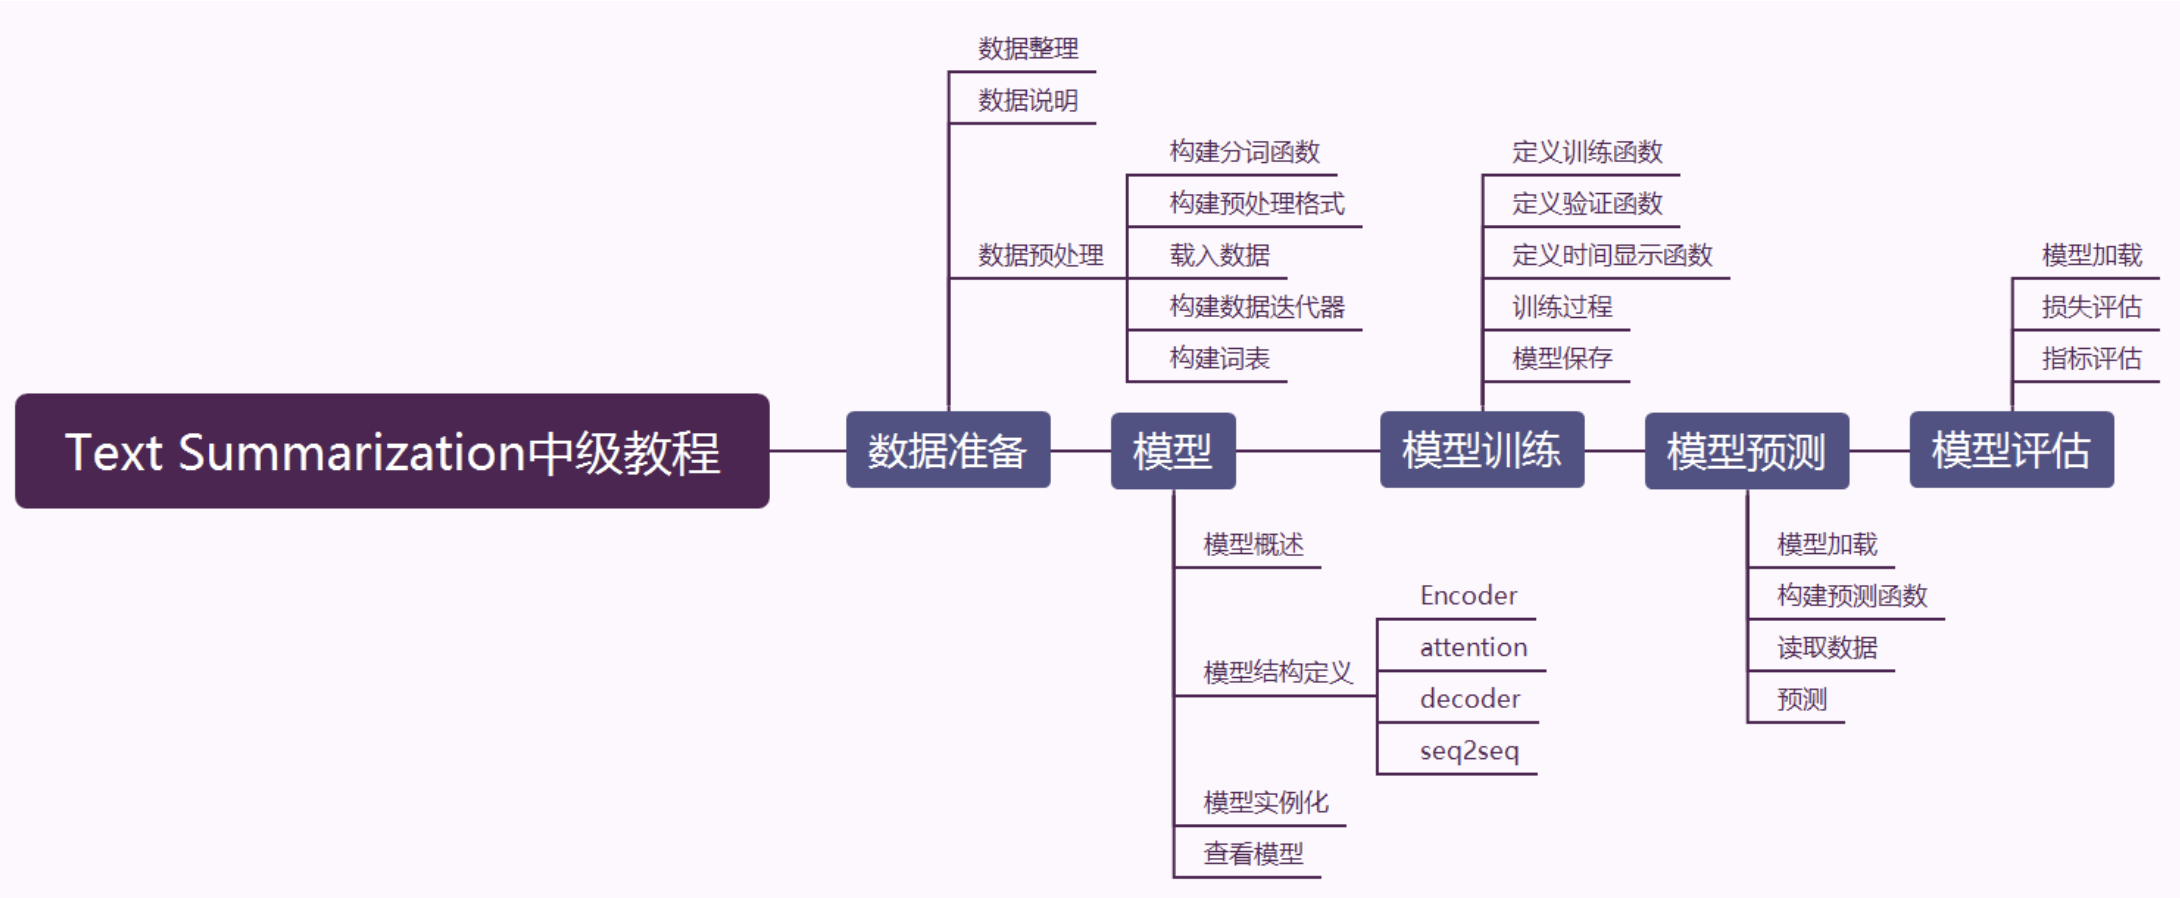

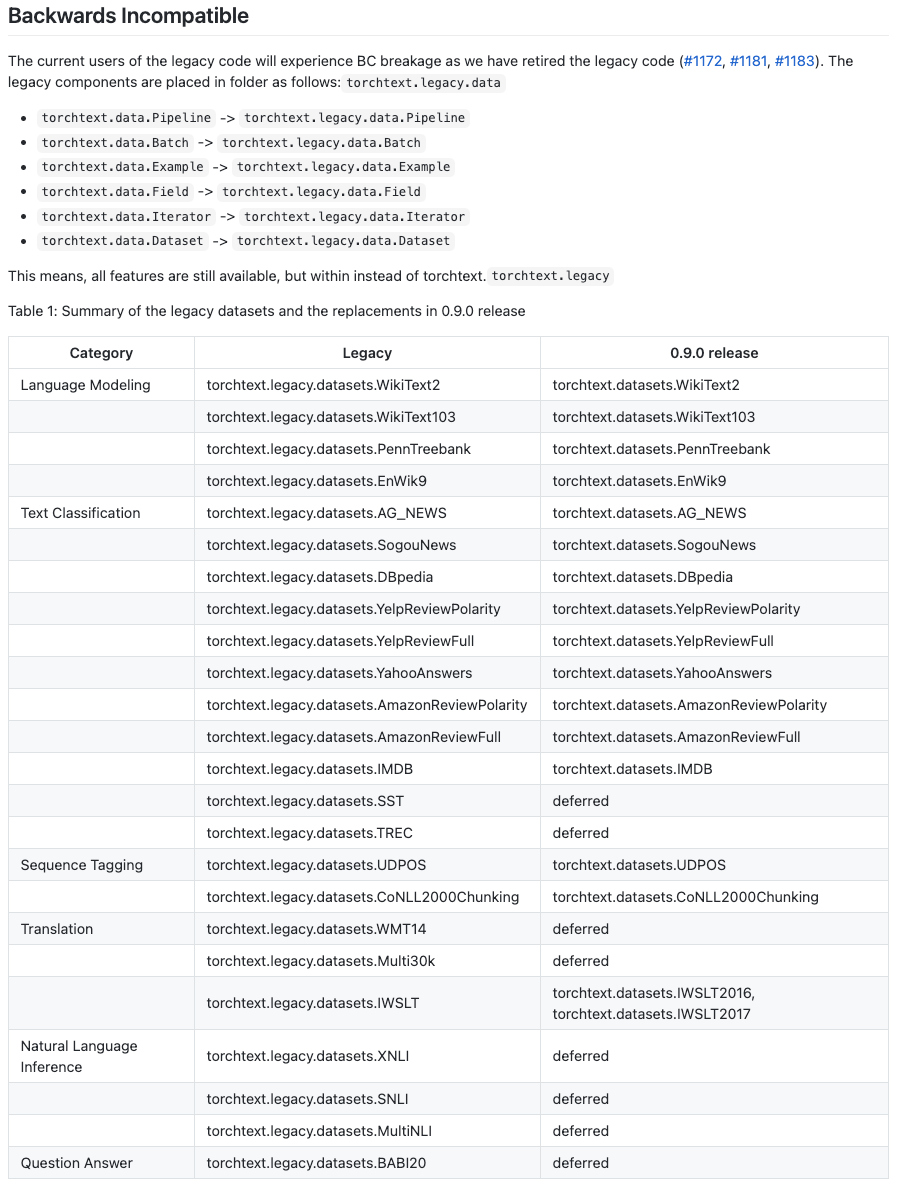
https://github.com/pytorch/text/releases/tag/v0.9.0-rc5

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import spacy
 
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field,Iterator,BucketIterator,TabularDataset

import pandas as pd
import numpy as np

import random
import math
import time

C:\Users\YSilhouette\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YSilhouette\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YSilhouette\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YSilhouette\AppData\Roami

In [3]:
# 全局初始化配置参数。 固定随机种子， 使得每次运行的结果相同
SEED = 22

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

## 数据准备
- 数据整理
- 数据说明
- 数据预处理

### 数据整理

In [4]:
data_train_path = "./dataset/train.csv"
data_test_path = "./dataset/test.csv"
data_val_path = "./dataset/val.csv"

### 数据说明

In [5]:
data_train = pd.read_csv(data_train_path,encoding="utf-8")

In [6]:
data_train.head()

,document,summary
0,jason blake of the islanders will miss the res...,blake missing rest of season
1,the u.s. military on wednesday captured a wife...,u.s. arrests wife and daughter of saddam deput...
2,craig bellamy 's future at west ham appeared i...,west ham drops bellamy amid transfer turmoil
3,cambridge - when barack obama sought advice be...,in search for expertise harvard looms large
4,"wall street held on to steep gains on monday ,...",wall street ends a three-day losing streak


### 数据预处理
- 构建分词函数
- 构建预处理格式
- 载入数据
- 构建数据迭代器
- 构建词表

#### 构建分词函数

In [7]:
# 加载spacy的英文处理包
spacy_en = spacy.load('en_core_web_sm')

In [8]:
# 构建分词函数， 返回文本里包含的所有词组的列表
def tokenize(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

#### 构建预处理格式

##### torchtext的Field函数可以构建预处理格式
- sequential：代表是否需要将数据序列化，大多数自然语言处理任务都是序列计算
- tokenize：需要传入分词函数，传入之前定义的tokenize函数
- lower：代表是否转换成小写，为了统一处理，把所有的字符转换成小写
- include_lengths：代表是否返回序列的长度，在gpu计算中，通常是对矩阵的运算，因此每个batch中，矩阵的长度为该batch中所有数据里最长的长度，其他长度不够的数据通常用pad字符补齐，这就会导致矩阵中有很多pad字符。为了后续的计算中把这些pad字符规避掉，我们需要返回每个数据的真实长度，这里的长度是指分词后每个文本中词组的数量
- init_token：传入起始符号，自然语言处理的任务中通常需要在文本的开头加入起始符号，作为句子的开始标记
- eos_token：传入结束符号，自然语言处理的任务中通常需要在文本的加入结束符号，作为句子的结束标记
- pad_token：传入pad符号，用来补全长度不够的文本，默认为  \<pad> 
- unk_token：传入unk符号，默认为 \<unk>。自然语言处理任务中，往往有一些词组不在我们构建的词表中，这种现场叫做00V（Out Of Vocabulary），用一个unk字符来表示这些字符。

In [9]:
DOCUMENT = Field(sequential=True, 
                tokenize=tokenize,
                lower=True,
                include_lengths=True,
               init_token='<sos>',
               eos_token='<eos>')

In [10]:
SUMMARY = Field(sequential=True, 
                tokenize=tokenize,
                lower=True,
                include_lengths=True,
               init_token='<sos>',
               eos_token='<eos>')

#### 载入数据

In [11]:
fields = [("document",DOCUMENT),("summary",SUMMARY)]

In [12]:
train = TabularDataset(path=data_train_path, format="csv", fields=fields, skip_header=True)
val = TabularDataset(path=data_val_path, format="csv", fields=fields, skip_header=True)
test = TabularDataset(path=data_test_path, format="csv", fields=fields, skip_header=True)

#### 构建数据迭代器
##### BucketIterator会自动将长度类似的文本归在一个batch，这样可以减少补全字符pad的数量，易于计算
- train：传入之前用TabularDataset载入的数据
- batch_size：传入每个批次包含的数据数量
- device：代表传入数据的设备，可以选择gpu或者cpu
- sort_within_batch：代表是否对一个批次内的数据排序
- sort_key：排序方式，由于要使用到pack_padded_sequence用来规避pad符号，而pack_padded_sequence需要数据以降序的形式排列，所以这里用document的长度进行降序。

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
BATCH_SIZE = 100 // 20
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, device=device, sort_key = lambda x :len(x.document), sort_within_batch=True)
val_iter = BucketIterator(val,batch_size=BATCH_SIZE, device=device, sort_key = lambda x:len(x.document), sort_within_batch=True)
test_iter = BucketIterator(test,batch_size=BATCH_SIZE, device=device, sort_key = lambda x:len(x.document), sort_within_batch=True)

#### 构建词表
往往将字符转换成数字，需要构建词表，用以用数字表示每个词组，并用来训练embedding。
- 在训练集上构建词表，频次低于min_freq的词组会被过滤。
- 构建完词表后会自动将迭代器数据中的字符转换成单词在词表中的序号。

在这里，我们对document和summary分别单独构建了词表，也可以只构建一个词表，使document和summary共享词表。

In [16]:
DOCUMENT.build_vocab(train,min_freq= 2)
SUMMARY.build_vocab(train,min_freq=2)

In [17]:
DOCUMENT.vocab.itos[:100]

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'the',
 '#',
 '.',
 ',',
 'a',
 'of',
 'to',
 'in',
 'and',
 'on',
 "'s",
 '-',
 'for',
 'said',
 'that',
 'with',
 'at',
 'an',
 '`',
 'as',
 'by',
 'from',
 'has',
 'his',
 'tuesday',
 'wednesday',
 'thursday',
 'its',
 'monday',
 'was',
 '<',
 '>',
 'unk',
 'is',
 'friday',
 'president',
 '-lrb-',
 '-rrb-',
 'after',
 'new',
 'will',
 'it',
 'two',
 'government',
 'their',
 'have',
 'u.s',
 'over',
 "''",
 'minister',
 'year',
 'china',
 'world',
 'first',
 'sunday',
 'he',
 'who',
 'saturday',
 'be',
 'here',
 'were',
 'against',
 'this',
 'people',
 'officials',
 'up',
 'are',
 'more',
 'country',
 'us',
 'united',
 'police',
 'percent',
 'one',
 'state',
 'reported',
 'into',
 'million',
 'last',
 'three',
 'official',
 'been',
 'than',
 'had',
 'not',
 'would',
 'but',
 'years',
 'about',
 'former',
 'prime',
 'states',
 'they',
 'international',
 'day',
 'week']

### 模型
- 模型概述
- 模型结构定义
- 模型实例化
- 查看模型

#### 模型该书
- seq2seq是一个Encoder–Decoder结构的网络，它的输入是一个序列，输出也是一个序列，seq2seq最早应用在翻译模型中，输入原文，输出为翻译后的译文。
- attention机制的用途是建立生成的译文中的每个单词和原文每个单词的联系，通过这种依赖关系，生成更精准的译文，seq2seq的结构如下图所示：
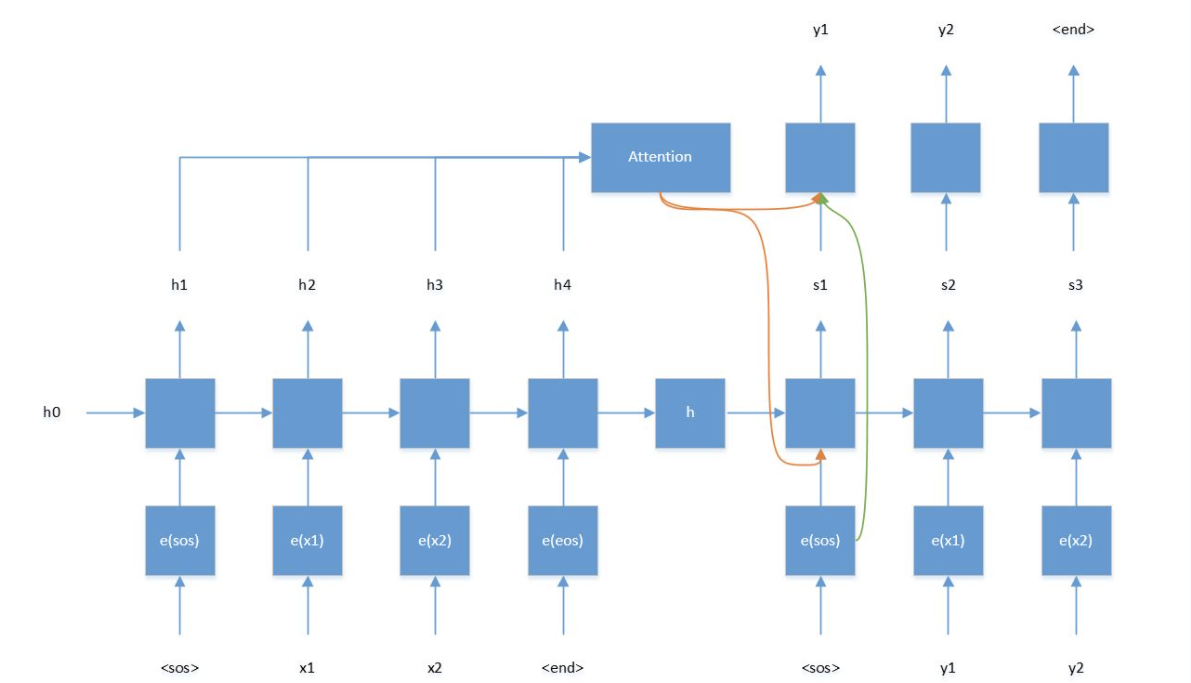

    - 左边为Encoder，是由rnn组成，顺序输入原文中单词的embedding，对于每个位置都输出一个hidden state $h_i$ 作为这个状态的表示，这个状态包含了之前所有单词的信息，待序列中所有的单词计算完后，Encoder输出一个变量 $h$ 作为整个序列的表示，这个变量可以直接是最后一个状态的表示，也可以对所有状态进行融合，将它们变换成一个固定维度的矩阵。
    -  右边是Decoder，它第一个状态的输入为Encoder的输出 $h$ 和 [单词的embedding; attention]，方括号内表示两个变量的连接，输出为 $s_j$ ，用[s_j; attention; embedding]预测这一步生成的单词，这里为了图像整体的简洁，没有画出attention对后面的状态的连接，实际上每一步生成都要连接attention。
    - Decoder和Encoder之间有一个attention，在最早的seq2seq模型中是没有attention的，Decoder直接接收Encoder的输出 $h$ ，这在生成译文单词的前期效果不错，但是随着生成单词的增多，rnn会逐渐遗忘掉 $h$ 的信息，这会导致生成的单词不够精准，而且无法建立原文和译文每个单词对应的关系，而attention由于在生成的每一步都会引入到生产过程中，并且每一步都计算Decoder的状态和Encoder每个状态的相似度用来建立关系，不仅使得生成效果更好，而且具有更强的可解释性，在很多翻译实验中，会把attention保存起来，建立一个attention的词表来观测不同语种单词之间的对应关系。

#### 模型结构定义
##### Encoder
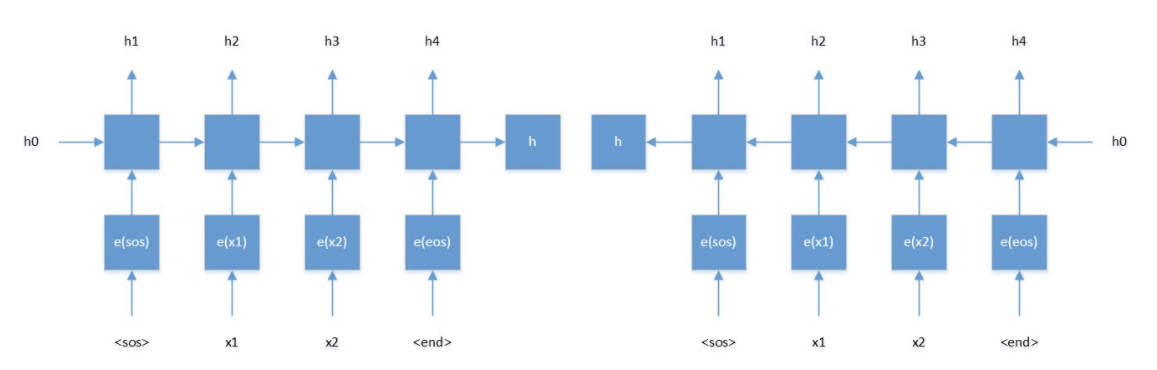

##### Decoder
- 这里为了获得上下文的语义表示，用了双向RNN，包含从sos向eos的前向RNN和从eos向sos的后向RNN，每个状态的表示变为前向RNN的输出和后向RNN的输出的连接 $[\vec{h_i}; \mathop{h_i} \limits ^{\leftarrow}]$，这样每个状态都包含了来自前文和后文的语义信息。
- Encoder的内部由RNN组成，RNN的形式为：
$h_i = RNN(h_{i-1},e(x_i))$
- 输入为前一个状态表示和这一步的单词的embedding。 $h_0$ 为一个全0矩阵，这里的RNN也可以替换成LSTM或者GRU。待所有的单词输入完毕后，Encoder会计算一个序列整体的表示，这里将前向RNN的最终输出和后向RNN输出的连接 $[\vec{h}; \mathop{h} \limits ^{\leftarrow}]$ 传入到一个全连接层进行变换，转换成Decoder输出的大小：
$hidden = tanh(w[\vec{h}; \mathop{h} \limits ^{\leftarrow}] + b )$
- Encoder函数构建一个encoder，内部RNN使用了torch内置的GRU，参数为：

  - input_dim：输入词表的大小
  - emb_dim：embedding的维度
  - enc_hid_dim：隐藏层的大小
  - dropout：dropout的概率
  
- forward参数：
  - doc：原文数据，是已经由词通过词表转换成序号的数据
  - doc_len：每个数据的真实长度，在计算RNN时，可以只计算相应长度的状态，不计算pad符号

- forword输出Encoder整体的输出，以及Encoder每个状态的输出。每个状态的输出用来计算后续的attention。
- 值得注意的是，为了规避掉后续计算attention时受到序列中存在pad符号的影响，这里应用了nn.utils的pad_paddad_sequence方法，可以去掉doc_len以后的pad符号，这里pad_packed_sequence的输入为单词序列的embedding和序列的真实长度，这样在计算序列时，就不会计算doc_len后的pad符号了。在计算完RNN后，为了形成一个矩阵方便GPU计算，会把每个doc_len < max_len 的序列填充起来，这里使用了pad_packed_sequence方法，输入为RNN计算后的序列packed_outputs，在后续的attention计算时，会把填充的信息规避掉。

In [18]:
# encoder的输入为原文， 输出为hidden_state, size需设置
class Encoder(nn.Module):
    def __init__(self,input_dim,emb_dim,enc_hid_dim, dec_hid_dim,dropout):
        super().__init__()
    
        # 定义embedding层， 直接使用 torch.nn.Embedding函数
        self.embedding = nn.Embedding(input_dim,emb_dim)

        # 定义rnn层， 使用torch.nn.GRU
        self.rnn = nn.GRU(emb_dim,enc_hid_dim,bidirection=True)

        # 定义一个 全连接层， 用来 将encoder的输出转换成 decoder输入的大小
        self.fc = nn.Linear(enc_hid_dim * 2 ,dec_hid_dim)

        # 定义dropout层， 防止过拟合
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,doc,doc_len):
        embeded = self.dropout(self.embedding(doc))
        
        packed_embeded = nn.utils.rnn.pack_padded_sequence(embeded,doc_len)
        
        # packed_outputs 包含了每个RNN中每个状态的输出，如图中的h1,h2,h3...hn
        # hidden只有最后的输出hn
        packed_outputs, hidden = self.rnn(packed_embeded)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]),dim=1)))
        
        return outputs,hidden

##### attention
- attention机制可以建立Decoder的状态 $s_i$ 和Encoder每个状态 $h_j$ 的关系，如下图所示：
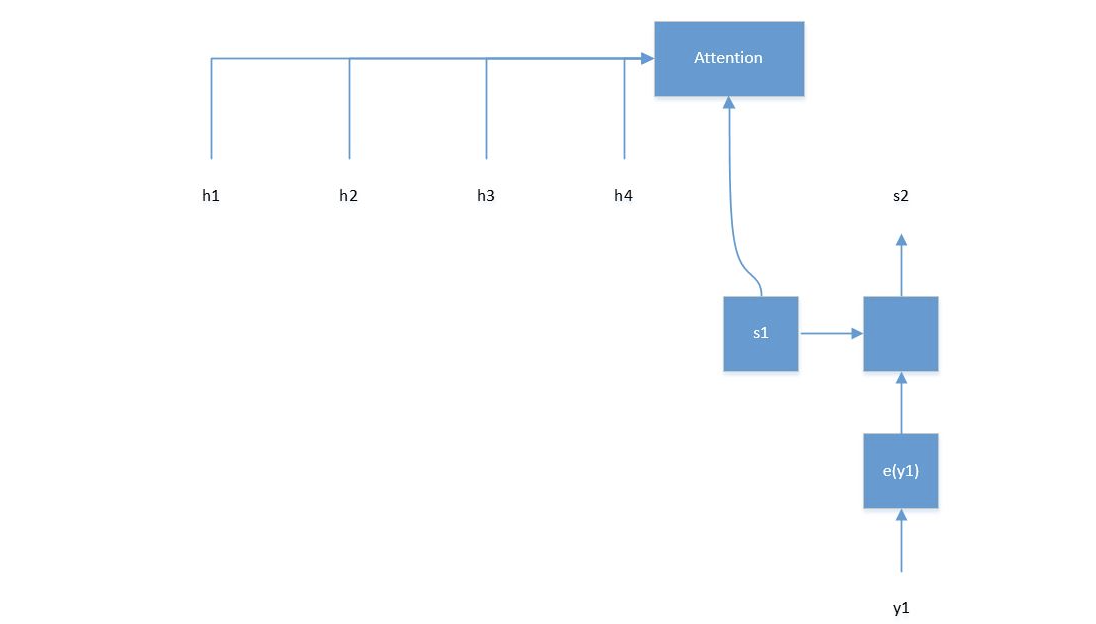
这里计算 $s_2$ 和 Encoder中每个状态的关系，需要用到 $s_1$ 的信息，先计算Decoder中 $s_{i-1}$ 和 Encodr状态 $h_{j}$ 的相似度：
$e_{ij} = a(s_{i-1}, hj)$
将 $[s_{i-1};h_{j}]$ 传入至一个全连接层计算相似度。
然后将$s_{i-1}$ 和 Encoder中每个状态的相似度做一个softmax变化，得到每个Encoder中每个状态所占的权重，作为attention：
$\alpha_{ij} = \frac{exp(e_{ij})}{\sum^{T}_{k = 1}(exp(e_{ik}))}$
attention中的每个权重会用来计算context vector，即上下文的向量：
$c_i = \sum_{k = 1}^{T} \alpha_{ij} h_j$
这个context vector会在Decoder中作为一部分输入。

- 构建Attention类，参数：
  - enc_hid_dim：encoder每个位置输出的维度
  - dec_hid_dim：decoder每个位置输出的维度

- forward的参数：
  - hidden：decoder里rnn前一个状态的输出
  - encoder_outs：encoder里rnn的输出
  - mask：mask矩阵，里面存储的是0-1矩阵，0代表被规避的pad符号的位置

- forword的输出为attention中的每个权重，context vector的计算在下面的Decoder类

In [20]:
class Attention(nn.Module):
    def __init__(self,enc_hid_dim,dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias= False)
        
    def forward(self,hidden, encoder_outputs, mask):
        batch_size = encoder_outputs.shape[1]
        doc_len = encoder_outputs.shape[0]
        
        # 对decoder的状态重复doc_len次，用来计算和每个encoder状态的相似度
        hidden = hidden.unsqueeze(1).repeat(1,doc_len,1)
        
        encoder_outputs = encoder_outputs.permute(1,0,2)
        # 使用全连接层计算相似度
        energy = torch.tanh(self.attn(torch.cat(hidden,encoder_outputs), dim=2))
        
        # 转换尺寸 [batch, doc_len]的形式作为 和每个encoder状态的相似度
        attention = self.v(energy).squeeze(2)
        
        # 规避encoder里的 pad符号， 将这些位置的权重值降到最低
        attention = attention.masked_fill(mask ==0, -1e10)
        
        # 返回权重
        return F.softmax(attention,dim=1)

#### decoder
- Decoder接收之前的状态信息、输入的单词和context vector，预测生成摘要的单词，结构如下所示：
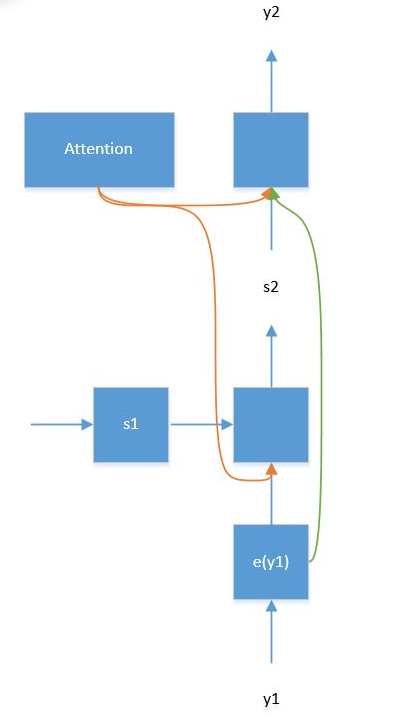
- Decoder的RNN与Encoder中的RNN有所不同，输入为[前一步生成单词的embedding;context vector]和前一步的状态 hi−1hi−1h_{i-1}，
- 目的是引入attention的信息：si=RNN([e(yi−1);c],si−1)si=RNN([e(yi−1);c],si−1)s_i = RNN([e(y_{i-1});c],s_{i-1})
- 在预测生成的单词时，将context vector、 RNN的输出状态、前一步生成单词的embedding连接起来输入至全连接层预测：yi=softmax(w[c;si;e(yi−1)]+b)yi=softmax(w[c;si;e(yi−1)]+b)y_i = softmax(w[c;s_i;e(y_{i-1})] + b)
- 构建Decoder类，参数为：
  - output_dim：输出的维度，为词表的长度
  - emb_dim：embedding的维度
  - enc_hid_dim：encoder每个位置输出的维度
  - dec_hid_dim：decoder每个位置输出的维度
  - dropout：dropout的概率
  - attention：需要传入attention类，用来计算decoder每个位置的输出和encoder每个位置的输出的关系
- forword参数：
  - input：输入单词的序号
  - hidden：上一步Decoder输出的状态
  - encoder_outputs：Encoder每个状态的输出，用来计算attention
  - mask：mask矩阵，用来在计算attention时，规避pad符号的影响
- forword输出为全连接层的输出、这一步Decoder的输出和attention的权重。这里输出的是预测时全连接层的输出，目的是计算后续的损失。

In [ ]:
class Decoder(nn.Module):
    def __init__(self,output_dim,emb_dim,enc_hid_dim,dec_hid_dim,dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim,emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim *2 )+ emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2))